# Figure 5: Skipped intronic site analysis

**Description:** Genomic context model development for intron sites.

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import genomic_context

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import test_proportions_2indep


## IMPORT DATA

In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation"

DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_05")
os.makedirs(OUTDIR, exist_ok = True)

ENCODE_DIR = os.path.join(PROJECT, "model", "rna_validation", "encode_project")


## Data loading and preparation

In [6]:
is_data = pd.read_csv(os.path.join(RESDIR, 'is_rawdata.txt'), sep = "\t")
print(is_data.shape)


(182248, 33)


#### Define features

In [7]:
is_feature_dict = {
    'intron_pos_3'               : '6. Site in last intron?',
    'up_exon_log10'              : '2. Upstream exon size (log10)',
    'down_exon_log10'            : '3. Downstream exon size (log10)',
    'distance_upstream5ss_log10' : "1. Distance to 5'SS (log10)",
    'score_first_upstream3ss'    : "4. Upstream 3'SS strength",
    'score_downstream3ss'        : "5. Downstream 3'SS strength",
    'ratio_3ss_to_3ss'           : "8. Ratio of downstream vs upstream 3'SS distance (log2)",
    'strength'                   : '7. PolyaStrength score',
}

is_features = list(is_feature_dict.keys())
is_labels = [is_feature_dict.get(_) for _ in is_features]


#### Transform features

In [8]:
is_data['gene'] = is_data['feature_gene']
is_data['intron_pos_3'] = (is_data['feature_score'] == 3).astype(int)

is_data['distance_upstream5ss_log10']       = np.log10(is_data['distance_upstream5ss'] + 1)
is_data['distance_first_upstream3ss_log10'] = np.log10(is_data['distance_first_upstream3ss'] + 1)
is_data['up_exon_log10']                    = np.log10(is_data['up_exon'] + 1)
is_data['down_exon_log10']                  = np.log10(is_data['down_exon'] + 1)

is_data['distance_downstream3ss'] = is_data['feature_size'] - is_data['distance_upstream5ss']
is_data['position_upstream5ss']   = is_data.apply(lambda row: (row['start'] - row['distance_upstream5ss']) if (row['strand'] == '+') else (row['start'] + row['distance_upstream5ss']), axis = 1)
is_data['position_downstream3ss'] = is_data.apply(lambda row: (row['start'] + row['distance_downstream3ss']) if (row['strand'] == '+') else (row['start'] - row['distance_downstream3ss']), axis = 1)

is_data['ratio_3ss_to_3ss'] = np.log2((is_data['distance_downstream3ss'] + 100) / (is_data['distance_first_upstream3ss'] + 100))


#### Subset sites in well-expressed genes

In [9]:
try:
    with open(os.path.join(RESDIR, 'refseq.hg38.genes.minUn.agg.reads.pickle'), mode = 'rb') as handle:
        gene_reads = pickle.load(handle)
        
except FileNotFoundError:
    
    with open(os.path.join(DATADIR, "reads3_scoring_dictionary.pickle"), mode = 'rb') as handle:
        reads_dict = pickle.load(handle)
        
    gene_reads = {}
        
    with open(os.path.join(RESDIR, 'refseq.hg38.genes.minUn.agg.bed'), mode = 'r') as handle:
        for line in handle:
            
            chrom, start, end, gene, score, strand = line.strip().split("\t")
            
            start = int(float(start))
            end   = int(float(end))
            
            gene_reads[gene] = np.sum([reads_dict.get((strand,chrom,x),0) for x in range(start,end)])

    with open(os.path.join(RESDIR, 'refseq.hg38.genes.minUn.agg.reads.pickle'), mode = 'wb') as handle:
        pickle.dump(gene_reads, handle)

is_data['gene_reads'] = is_data['gene'].apply(lambda x : gene_reads[x])


In [10]:
condWELLEXP   = (is_data['gene_reads'] >= 100)
condNOMISSING = ~(is_data[is_features].isnull().any(axis = 1))
print(is_data.shape, condWELLEXP.sum(), condNOMISSING.sum())

is_filt = is_data.loc[condWELLEXP & condNOMISSING].copy()
print(is_filt.shape)


(182248, 43) 170656 182248
(170656, 43)


#### Identify positive sites

In [11]:
is_pos = is_filt.loc[is_filt['cluster_reads_slop'] > 0].copy()

is_site_dict = {}

for i,row in is_pos.iterrows():
    is_site_dict[(row['chrom'], row['start'], row['strand'], row['gene'])] = row['cluster_reads_slop']


In [12]:
is_positives = is_filt.loc[is_filt['cluster_reads_slop'] >= 100].copy()
is_negatives = is_filt.loc[is_filt['cluster_reads_slop'] == 0].copy()

print("POSITIVES:", is_positives.shape)
print("NEGATIVES:", is_negatives.shape)


POSITIVES: (3284, 43)
NEGATIVES: (156564, 43)


#### Sample negative sites from introns with no used polyA sites

In [13]:
# random_state = np.random.randint(0, 2**32 - 1)
random_state = 1963451475
print(random_state)

is_negatives_samp = is_negatives.sample(n = 50000, replace = False, random_state = random_state)
is_negatives_samp['nc_eligible'] = is_negatives_samp.apply(genomic_context.check_sites_in_intron, args = (is_pos, is_site_dict), axis = 1)
print("ELIGIBLE NCs:", is_negatives_samp.nc_eligible.sum())


1963451475
ELIGIBLE NCs: 6368


In [14]:
is_negatives_maxpergene = genomic_context.downsample_sites_per_gene(is_negatives_samp.loc[is_negatives_samp['nc_eligible'] == True], 
                                                                    is_positives['gene'].value_counts().max(),
                                                                    random_state = random_state)
print("DOWNSAMPLED NCs:", is_negatives_maxpergene.shape)


DOWNSAMPLED NCs: (4209, 44)


#### Partition data into training/testing splits

In [15]:
is_positives = is_filt.loc[is_filt['cluster_reads_slop'] >= 100].copy()
is_positives['split'] = 'train'
is_positives.loc[is_positives.sample(frac = 0.1, replace = False, random_state = random_state).index, 'split'] = 'test'

is_negatives = is_negatives_maxpergene.loc[is_negatives_maxpergene['nc_eligible'] == 1].copy().sample(n = len(is_positives), replace = False, random_state = random_state)
is_negatives['split'] = 'train'
is_negatives.loc[is_negatives.sample(frac = 0.1, replace = False, random_state = random_state).index, 'split'] = 'test'

new_is_data = pd.concat([is_positives, is_negatives], sort = False, ignore_index = True)
print("\nBINARY CLASS:\n", new_is_data.score_binary.value_counts())
print("\nSPLIT:\n", new_is_data.split.value_counts())

with open(os.path.join(RESDIR, 'is_data.pickle'), mode = 'wb') as handle:
    pickle.dump(new_is_data, handle)



BINARY CLASS:
 1    3284
0    3284
Name: score_binary, dtype: int64

SPLIT:
 train    5912
test      656
Name: split, dtype: int64


#### Scale data to normalize mean and standard deviation

In [16]:
scaler_is = StandardScaler().fit(new_is_data.loc[new_is_data['split'] == 'train', is_features[1:]])

with open(os.path.join(RESDIR, 'is_scaler_ratio.pickle'), mode = 'wb') as handle:
    pickle.dump(scaler_is, handle)

Xall_scaled = pd.DataFrame(scaler_is.transform(new_is_data[is_features[1:]]), index = new_is_data.index, columns = new_is_data[is_features[1:]].columns)
Xall_scaled[is_features[0]] = new_is_data[is_features[0]]
Yall_c = new_is_data['score_binary']

Xtr_scaled = Xall_scaled.loc[new_is_data['split'] == 'train'].copy()
Ytr_c = new_is_data.loc[new_is_data['split'] == 'train', 'score_binary'].copy()

Xte_scaled = Xall_scaled.loc[new_is_data['split'] == 'test'].copy()
Yte_c = new_is_data.loc[new_is_data['split'] == 'test', 'score_binary'].copy()

is_all_data = {
    'train' : {
        'X' : Xtr_scaled,
        'Y' : Ytr_c,
    },
    'test' : {
        'X' : Xte_scaled,
        'Y' : Yte_c,
    }
}


#### Fit logistic regression model

In [17]:
is_model = sm.Logit(Ytr_c, Xtr_scaled[is_features]).fit()
print(is_model.summary())

with open(os.path.join(RESDIR, 'is_model_ratio.pickle'), mode = 'wb') as handle:
    pickle.dump(is_model, handle)


Optimization terminated successfully.
         Current function value: 0.411585
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           score_binary   No. Observations:                 5912
Model:                          Logit   Df Residuals:                     5904
Method:                           MLE   Df Model:                            7
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.4062
Time:                        14:46:56   Log-Likelihood:                -2433.3
converged:                       True   LL-Null:                       -4097.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intron_pos_3                   1.6633      0.108     15.387      0.000      

In [18]:
is_all_data['train']['Ypred'] = {}
is_all_data['test']['Ypred']  = {}
    
new_preds = is_model.predict(is_all_data['train']['X'][is_features])
is_all_data['train']['Ypred'] = new_preds

new_preds = is_model.predict(is_all_data['test']['X'][is_features])
is_all_data['test']['Ypred'] = new_preds


## Classification Performance

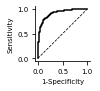

Corresponding metrics:
	Test AUROC = 0.9107581052944677


In [19]:
fig,axes = plt.subplots(1,1, figsize = (1,1))

is_filt_auc = genomic_context.plot_roc(axes, 
                                       is_all_data['test']['Y'],
                                       is_all_data['test']['Ypred'],
                                       'Test')

axes.xaxis.set_major_locator(MultipleLocator(0.5))
axes.yaxis.set_major_locator(MultipleLocator(0.5))

axes.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'is.classification_roc.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print(f"\tTest AUROC = {is_filt_auc}")


## Validation of site usage predictions using ENCODE RNA-seq

In [20]:
## load site data with genomic context fields

is_site_data = is_filt

is_site_data_scaled = pd.DataFrame(scaler_is.transform(is_site_data[is_features[1:]]), index = is_site_data.index, columns = is_site_data[is_features[1:]].columns)
is_site_data_scaled['intron_pos_3'] = is_site_data['intron_pos_3']

is_site_data['pred_prob'] = is_model.predict(is_site_data_scaled[is_features])
print(is_site_data.shape)


## filter sites with sufficient reads

is_site_pos = is_site_data.loc[is_site_data['cluster_reads_slop'] >= 10].copy()
is_site_neg = is_site_data.loc[is_site_data['cluster_reads_slop'] == 0].copy().sample(n = is_site_pos.shape[0], replace = False, random_state = random_state)

is_site_filt = pd.concat([is_site_pos, is_site_neg], sort = False, ignore_index = True)
print(is_site_filt.shape)


(170656, 44)
(16288, 44)


Original data shape: (16288, 44)
Filtered data shape: (16178, 44)
Output results shape: (16178, 2)


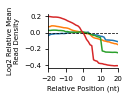

In [28]:
fig, ax = plt.subplots(1,1, figsize = (1.25,1))

distance = 20
is_a172_res = genomic_context.quantify_reads_around(is_site_filt, ENCODE_DIR, 'A172', distance = distance, subset = [('distance_upstream5ss', distance+5), ('distance_downstream3ss', distance+5)])
genomic_context.make_read_plots(ax, is_a172_res, 'skipped_intron', 'A172', distance)

ax.axhline(y = 0, color = 'black', linestyle = 'dashed', linewidth = 0.75)
ax.set_xlim((-distance,distance))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(0.2))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'is.rna_validation.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


## AUROC for individual predictors

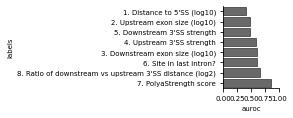

Corresponding data:
                                              labels     auroc     auprc
3                        1. Distance to 5'SS (log10)  0.409843  0.428766
1                      2. Upstream exon size (log10)  0.483274  0.494499
5                        5. Downstream 3'SS strength  0.488005  0.481924
4                          4. Upstream 3'SS strength  0.589279  0.560606
2                    3. Downstream exon size (log10)  0.606024  0.580513
0                            6. Site in last intron?  0.612805  0.745720
6  8. Ratio of downstream vs upstream 3'SS distan...  0.668594  0.597427
7                             7. PolyaStrength score  0.859078  0.865150


In [22]:
is_test_data = new_is_data.loc[new_is_data['split'] == 'test']

is_aurocs = []
is_auprcs = []

for icf,icl in zip(is_features, is_labels):
    auroc, auprc = genomic_context.calculate_auc(is_test_data['score_binary'], is_test_data[icf])
    is_aurocs.append(auroc)
    is_auprcs.append(auprc)
    
is_aurocs_df = pd.DataFrame.from_dict({'labels' : is_labels, 'auroc' : is_aurocs, 'auprc' : is_auprcs}, orient = 'columns')

fig,ax = plt.subplots(1,1, figsize = (1, 1.5))

sns.barplot(data = is_aurocs_df.sort_values('auroc'),
            x = 'auroc', y = 'labels', color = 'dimgray',
            edgecolor = 'black', linewidth = 0.5,
            ax = ax)

ax.set_xlim(0,1)
ax.xaxis.set_major_locator(MultipleLocator(0.25))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'is.individual_predictor_auroc.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(is_aurocs_df.sort_values('auroc'))


## Confirmatory boxplots for model predictors

In [23]:
class_names = {0:'Not Used', 1:'Highly Used'}
class_order = ['Highly Used', 'Not Used']

is_pred = new_is_data.copy()
is_pred['pred_prob'] = is_all_data['train']['Ypred']
is_pred.loc[is_pred['split'] == 'test', 'pred_prob'] = is_all_data['test']['Ypred']

is_pred['class'] = is_pred['score_binary'].apply(lambda x : class_names[x])
is_pred['pred_prob_clip'] = np.clip(is_pred['pred_prob'], 1e-6, 1 - 1e-6)
is_pred['pred_prob_or'] = np.log2(is_pred['pred_prob_clip'] / (1 - is_pred['pred_prob_clip']))

print(is_pred.shape)


(6568, 49)


In [29]:
selected_features = ['distance_upstream5ss_log10', 'up_exon_log10', 'down_exon_log10', 
                     'score_first_upstream3ss', 'score_downstream3ss', 'ratio_3ss_to_3ss']

selected_labels = [is_feature_dict.get(sf) for sf in selected_features]


#### PolyaStrength by site usage

7. PolyaStrength score:
N_Highly Used	N=3284
N_Not Used	N=3284
Baseline	WRS P-val = 0.000E+00


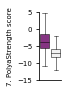

In [30]:
genomic_context.boxplot_features_outcome(OUTDIR, is_pred, 'is',
                                         ['strength'], [is_feature_dict.get('strength')],
                                         'class', class_order, ['#92278f','#f2f2f2'],
                                         figsize = (0.4,1.25), ylims_main=(-15,5), ytickint_main = 5)


#### Genomic features after controlling for PolyaStrength via quantile sampling



1. Distance to 5'SS (log10)
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


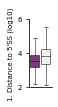

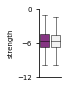

1. Distance to 5'SS (log10):
N_Highly Used	N=1146
N_Not Used	N=1146
Baseline	WRS P-val = 5.900E-32
strength	WRS P-val = 5.388E-01


In [31]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[0]], [selected_labels[0]], 
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(2,6), ytickint_main = 2, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




2. Upstream exon size (log10)
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


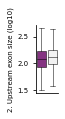

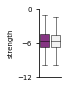

2. Upstream exon size (log10):
N_Highly Used	N=1146
N_Not Used	N=1146
Baseline	WRS P-val = 1.080E-03
strength	WRS P-val = 5.388E-01


In [33]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[1]], [selected_labels[1]], 
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(None), ytickint_main = 0.5, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




3. Downstream exon size (log10)
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


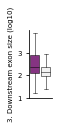

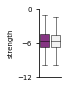

3. Downstream exon size (log10):
N_Highly Used	N=1146
N_Not Used	N=1146
Baseline	WRS P-val = 2.338E-31
strength	WRS P-val = 5.388E-01


In [34]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[2]], [selected_labels[2]],
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(1,None), ytickint_main = 1, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




4. Upstream 3'SS strength
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


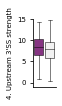

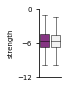

4. Upstream 3'SS strength:
N_Highly Used	N=1146
N_Not Used	N=1146
Baseline	WRS P-val = 3.890E-07
strength	WRS P-val = 5.388E-01


In [35]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[3]], [selected_labels[3]],
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(-1,15), ytickint_main = 5, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




5. Downstream 3'SS strength
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


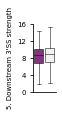

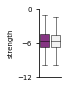

5. Downstream 3'SS strength:
N_Highly Used	N=1146
N_Not Used	N=1146
Baseline	WRS P-val = 2.017E-01
strength	WRS P-val = 5.388E-01


In [36]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[4]], [selected_labels[4]],
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(0,16), ytickint_main = 4,
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




8. Ratio of downstream vs upstream 3'SS distance (log2)
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


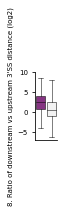

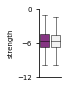

8. Ratio of downstream vs upstream 3'SS distance (log2):
N_Highly Used	N=1146
N_Not Used	N=1146
Baseline	WRS P-val = 2.231E-44
strength	WRS P-val = 5.388E-01


In [37]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, is_pred, 'is',
                                                                [selected_features[5]], [selected_labels[5]],
                                                                'class', class_order, ['#92278f','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(-7,10), ytickint_main = 5, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




6. Site in last intron?
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


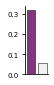

Corresponding Statistics:
statistic = 17.4282273969644
pvalue = 5.038372566226599e-68
compare = diff
method = agresti-caffo
diff = 0.26788830715532286
ratio = 5.951612903225806
odds_ratio = 8.303151077344625
variance = 0.0002354434100258364
alternative = two-sided
value = 0
tuple = (17.4282273969644, 5.038372566226599e-68)


In [38]:
is_ip3_sampled = genomic_context.quantile_sampling(is_pred, 'is', 
                                                   ['intron_pos_3'], [is_feature_dict.get('intron_pos_3')], 
                                                   'class', class_order, sample = ['strength'], random_state = random_state)

is_sum = (is_ip3_sampled
          .groupby(['class','intron_pos_3']).size()
          .reset_index().rename(columns = {0:'count'}))

is_sum['prop'] = is_sum['count'] / is_sum.groupby('class')['count'].transform('sum')

is_test = test_proportions_2indep(is_sum.loc[(is_sum['class'] == 'Highly Used') & (is_sum['intron_pos_3'] == 1), 'count'].iloc[0],
                                  is_sum.loc[(is_sum['class'] == 'Highly Used'), 'count'].sum(),
                                  is_sum.loc[(is_sum['class'] == 'Not Used') & (is_sum['intron_pos_3'] == 1), 'count'].iloc[0],
                                  is_sum.loc[(is_sum['class'] == 'Not Used'), 'count'].sum())

is_sum = is_sum.loc[is_sum['intron_pos_3'] == 1]


fig,ax = plt.subplots(1,1, figsize = (0.4, 1.25))

sns.barplot(data = is_sum, x = 'class', y = 'prop', order = class_order,
            hue = 'class', hue_order = class_order, dodge = False, palette = ['#92278f','#f2f2f2'],
            edgecolor = 'black', linewidth = 0.5)

ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(0,None)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.set_xticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'is.intron_pos_3_by_usage.quantile_sampling.controlling_predicted_logit.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding Statistics:")
print(is_test)
